# Model Building & Experimentation

## Data Collection

In [353]:
# Packages
import numpy as np
import pandas as pd
import xarray as xr

In [355]:
!ls

Data_Download.ipynb Setup.ipynb         gee_downloads       test_dir
Experiment00.ipynb  TCD2_Models.ipynb   logs.log
Model_Dev00.ipynb   catboost_info       test-output


In [357]:
data = pd.read_csv('gee_downloads/s2path_data.csv')
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,dataset,SMonth,SDay,HMonth,HDay,MonthBetw,CorrectSDate,CorrectHDate,CorrectMonthBetw,tif_path
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25,2024-04-14,97,54,...,train,11,25,4,14,4,2023-11-25,2024-04-14,4,gee_downloads/20240412T050649_20240412T051727_...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13,2024-04-26,82,58,...,train,11,13,4,26,5,2023-11-13,2024-04-26,5,gee_downloads/20240425T051649_20240425T052817_...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19,2024-04-28,92,91,...,train,12,19,4,28,4,2023-12-19,2024-04-28,4,gee_downloads/20240427T050651_20240427T051439_...
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11,2024-11-04,91,52,...,train,2,11,11,4,21,2023-11-02,2024-11-04,12,gee_downloads/20241103T050951_20241103T052004_...
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12,2024-05-19,94,55,...,train,12,12,5,19,5,2023-12-12,2024-05-19,5,gee_downloads/20240517T050651_20240517T051655_...


In [359]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10606 entries, 0 to 10605
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FarmID            10606 non-null  int64 
 1   category          7888 non-null   object
 2   Crop              10606 non-null  object
 3   State             10606 non-null  object
 4   District          10606 non-null  object
 5   Sub-District      10606 non-null  object
 6   SDate             10606 non-null  object
 7   HDate             10606 non-null  object
 8   CropCoveredArea   10606 non-null  int64 
 9   CHeight           10606 non-null  int64 
 10  CNext             10606 non-null  object
 11  CLast             10606 non-null  object
 12  CTransp           10606 non-null  object
 13  IrriType          10606 non-null  object
 14  IrriSource        10606 non-null  object
 15  IrriCount         10606 non-null  int64 
 16  WaterCov          10606 non-null  int64 
 17  ExpYield    

In [361]:
train_data = data[data.dataset == 'train']
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7888 entries, 0 to 10564
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FarmID            7888 non-null   int64 
 1   category          7888 non-null   object
 2   Crop              7888 non-null   object
 3   State             7888 non-null   object
 4   District          7888 non-null   object
 5   Sub-District      7888 non-null   object
 6   SDate             7888 non-null   object
 7   HDate             7888 non-null   object
 8   CropCoveredArea   7888 non-null   int64 
 9   CHeight           7888 non-null   int64 
 10  CNext             7888 non-null   object
 11  CLast             7888 non-null   object
 12  CTransp           7888 non-null   object
 13  IrriType          7888 non-null   object
 14  IrriSource        7888 non-null   object
 15  IrriCount         7888 non-null   int64 
 16  WaterCov          7888 non-null   int64 
 17  ExpYield          

In [363]:
train_data = train_data[(train_data.CorrectMonthBetw > 0) & (train_data.CorrectMonthBetw < 10)]

## Preprocessing

### Images Indices calculation

In [367]:
import xarray as xr

def compute_indices(tif_path):
    """
    Reads a 10-band Sentinel-2 GeoTIFF from `tif_path` and computes vegetation indices.
    Returns a dictionary of mean index values.
    """
    # Open the 10-band DataArray (assuming 'band' is the first dimension)
    data_array = xr.open_dataarray(tif_path)

    # Extract each band by index (assuming band=0 -> B2, band=1 -> B3, etc.)
    B2  = data_array.isel(band=0).astype(float)  # Blue
    B3  = data_array.isel(band=1).astype(float)  # Green
    B4  = data_array.isel(band=2).astype(float)  # Red
    B5  = data_array.isel(band=3).astype(float)  # Red Edge
    B6  = data_array.isel(band=4)
    B7  = data_array.isel(band=5)
    B8  = data_array.isel(band=6).astype(float)  # NIR (wide)
    B8A = data_array.isel(band=7).astype(float)  # NIR (narrow)
    B11 = data_array.isel(band=8).astype(float)  # SWIR1
    B12 = data_array.isel(band=9).astype(float)  # SWIR2

    # Normalize bands by dividing by 10000 (to match Sentinel-2 reflectance scaling)
    B2 /= 10000
    B3 /= 10000
    B4 /= 10000
    B5 /= 10000
    B8 /= 10000
    B8A /= 10000
    B11 /= 10000

    # --- Compute Indices (all band computations in float) ---
    EPSILON = 1e-10  # To avoid division by zero
    
    # 1. NDVI: (NIR - RED) / (NIR + RED)
    ndvi = (B8 - B4) / (B8 + B4 + EPSILON)

    # 2. EVI (with normalized bands): 2.5 * (NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1)
    evi = 2.5 * (B8 - B4) / (B8 + 6.0 * B4 - 7.5 * B2 + 1.0 + EPSILON)

    # 3. NDWI: (GREEN - NIR) / (GREEN + NIR)
    ndwi = (B3 - B8) / (B3 + B8 + EPSILON)

    # 4. GNDVI: (NIR - GREEN) / (NIR + GREEN)
    gndvi = (B8 - B3) / (B8 + B3 + EPSILON)

    # 5. SAVI: (1 + L) * (NIR - RED) / (NIR + RED + L)
    L = 0.5  # Soil adjustment factor
    savi = (1.0 + L) * (B8 - B4) / (B8 + B4 + L + EPSILON)

    # 6. MSAVI: (2*NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR - RED))) / 2
    msavi = (2.0 * B8 + 1.0 - np.sqrt((2.0 * B8 + 1.0)**2 - 8.0 * (B8 - B4))) / 2.0

    # 7. Moisture Index: (B8A - B11) / (B8A + B11)
    moisture_idx = (B8A - B11) / (B8A + B11 + EPSILON)
    
    # 8. NDRE: (NIR - RedEdge) / (NIR + RedEdge)
    ndre = (B8 - B5) / (B8 + B5 + EPSILON)

    # 9. CCCI: NDRE / NDVI
    ccci = ndre / (ndvi + EPSILON)  # Add EPSILON to avoid zero division
    
    # --- Compute means for each index across the array ---
    result = {
        'NDVI': ndvi.mean().item(),
        'EVI': evi.mean().item(),
        'NDWI': ndwi.mean().item(),
        'GNDVI': gndvi.mean().item(),
        'SAVI': savi.mean().item(),
        'MSAVI': msavi.mean().item(),
        'MoistureIndex': moisture_idx.mean().item(),
        'NDRE': ndre.mean().item(),
        'CCCI': ccci.mean().item()
    }

    # Close the data to free memory
    data_array.close()
    
    return result

def compute_indices_for_df(final_trdf, tif_path_col='tif_path'):
    """
    For each row in `final_trdf`, read the TIF file path,
    compute vegetation indices, and store the results as new columns.
    """
    # List or dictionary to store results
    # We'll append directly to the dataframe for convenience
    index_columns = [
        'NDVI', 'EVI', 'NDWI', 'GNDVI', 'SAVI', 'MSAVI', 
        'MoistureIndex', 'NDRE', 'CCCI'
    ]

    # Initialize columns to NaN in case of errors or missing files
    for col in index_columns:
        final_trdf[col] = np.nan

    # Iterate over rows to compute and assign index values
    for idx, row in final_trdf.iterrows():
        tif_path = row[tif_path_col]
        if not isinstance(tif_path, str):
            print(f"Skipping index {idx} due to invalid path: {tif_path}")
            continue

        try:
            # Compute the indices
            result = compute_indices(tif_path)

            # Assign values to dataframe columns
            for k, v in result.items():
                final_trdf.at[idx, k] = v

        except Exception as e:
            print(f"Error processing row {idx} with TIF path {tif_path}: {e}")

    return final_trdf

In [369]:
%%time
train_idf = compute_indices_for_df(train_data, tif_path_col='tif_path')

CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 17.2 μs


In [371]:
train_data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,tif_path,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25,2024-04-14,97,54,...,gee_downloads/20240412T050649_20240412T051727_...,0.108712,0.163293,-0.153967,0.153967,0.098089,0.094265,0.121053,0.013156,-0.005251
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13,2024-04-26,82,58,...,gee_downloads/20240425T051649_20240425T052817_...,0.197968,0.362191,-0.193252,0.193252,0.159491,0.148534,-0.037014,0.004742,0.023030
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19,2024-04-28,92,91,...,gee_downloads/20240427T050651_20240427T051439_...,0.202412,0.342884,-0.207029,0.207029,0.168543,0.158716,-0.041077,0.023218,0.112474
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12,2024-05-19,94,55,...,gee_downloads/20240517T050651_20240517T051655_...,0.199852,0.673206,-0.184704,0.184704,0.180863,0.174953,-0.082711,0.025535,0.126281
5,1326580,Pests,Paddy,Telangana,Medak,Kulcharam,2023-12-13,2024-05-18,97,51,...,gee_downloads/20240517T050651_20240517T051655_...,0.165032,0.358449,-0.162412,0.162412,0.140404,0.132625,-0.054915,0.036126,0.218214


In [373]:
train_idf.columns

Index(['FarmID', 'category', 'Crop', 'State', 'District', 'Sub-District',
       'SDate', 'HDate', 'CropCoveredArea', 'CHeight', 'CNext', 'CLast',
       'CTransp', 'IrriType', 'IrriSource', 'IrriCount', 'WaterCov',
       'ExpYield', 'Season', 'geometry', 'dataset', 'SMonth', 'SDay', 'HMonth',
       'HDay', 'MonthBetw', 'CorrectSDate', 'CorrectHDate', 'CorrectMonthBetw',
       'tif_path', 'NDVI', 'EVI', 'NDWI', 'GNDVI', 'SAVI', 'MSAVI',
       'MoistureIndex', 'NDRE', 'CCCI'],
      dtype='object')

In [375]:
# Create total days between S & H
train_idf['CorrectSDate'] = pd.to_datetime(train_idf['CorrectSDate'])
train_idf['CorrectHDate'] = pd.to_datetime(train_idf['CorrectHDate'])
train_idf['TDays'] = (train_idf.CorrectHDate - train_idf.CorrectSDate).dt.days

to_drop = ['FarmID', 'State', 'District', 'Sub-District', 'SDate', 'HDate', 'geometry', 'dataset', 'SMonth', 'SDay', 'HMonth',
       'HDay', 'MonthBetw', 'CorrectSDate', 'CorrectHDate', 'CorrectMonthBetw',
       'tif_path']

train_idf = train_idf.drop(columns = to_drop) 

In [377]:
train_idf.describe()

,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays
count,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7.071000e+03,7080.000000
mean,77.804237,87.307062,3.520198,56.885876,15.896045,0.160094,0.284980,-0.179778,0.179778,0.133377,0.125995,0.067368,0.017439,1.554013e+04,136.732345
std,14.186280,51.193517,1.415767,23.124670,5.580619,0.085769,1.247951,0.081404,0.081404,0.072050,0.069040,0.124125,0.013670,3.056858e+05,49.318162
min,40.000000,20.000000,1.000000,20.000000,5.000000,-0.101148,-19.056145,-0.439765,-0.043751,-0.077626,-0.074347,-0.164953,-0.087368,-4.981733e+06,30.000000
25%,67.000000,51.000000,2.000000,40.000000,11.000000,0.095105,0.154297,-0.226298,0.120737,0.077680,0.072493,-0.027921,0.009994,5.310537e-02,103.000000
50%,79.000000,75.000000,4.000000,51.000000,15.000000,0.165626,0.255762,-0.181226,0.181226,0.135231,0.126301,0.037125,0.016143,9.593426e-02,131.000000
75%,90.000000,101.000000,5.000000,82.000000,20.000000,0.216601,0.342067,-0.120737,0.226298,0.181074,0.171196,0.152847,0.023039,1.989960e-01,162.000000
max,100.000000,250.000000,6.000000,100.000000,30.000000,0.424395,96.387720,0.043751,0.439765,0.378199,0.371833,0.636575,0.156441,1.409063e+07,299.000000


In [379]:
train_idf.describe(include='O')

,category,Crop,CNext,CLast,CTransp,IrriType,IrriSource,Season
count,7080,7080,7080,7080,7080,7080,7080,7080
unique,4,7,10,10,4,4,5,2
top,Healthy,Paddy,Wheat,Lentil,Transplanting,Drip,Groundwater,Rabi
freq,5850,2049,1248,1205,2049,2568,3005,5453


In [381]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numerical_distributions(df, target_col=None):
    """
    Plots histogram, violin plot, and line plot for each numerical column in the DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing numerical columns.
        
    target_col : str, optional
        Column to exclude from plotting (e.g., 'Target'). Default is None.
    """
    
    # Drop target column if provided
    if target_col and target_col in df.columns:
        cols = df.drop([target_col], axis=1).select_dtypes(include='number').columns
    else:
        cols = df.select_dtypes(include='number').columns
    
    # Loop over each numerical column
    for col in cols:
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        
        # Histogram for distribution
        sns.histplot(df[col], kde=True, bins=30, ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')

        # Violin plot for spread and distribution
        sns.violinplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Violin Plot of {col}')

        # Line plot to observe value progression
        sns.lineplot(data=df[col], ax=axes[2], marker="o", color='r')
        axes[2].set_title(f'Line Plot of {col}')

        # Adjust layout for better readability
        plt.tight_layout()
        plt.show()

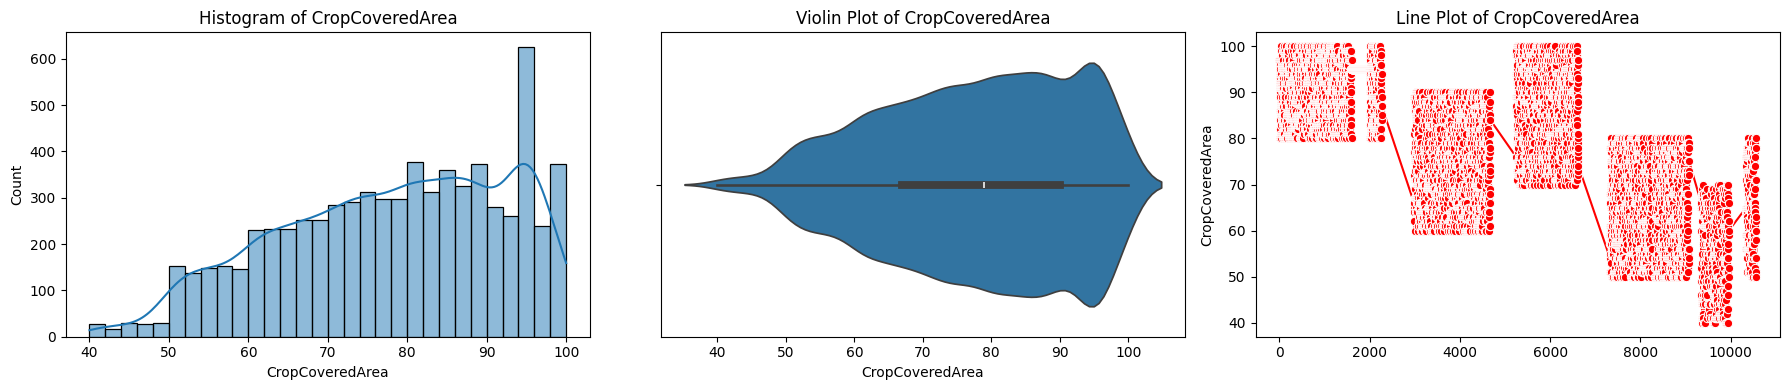

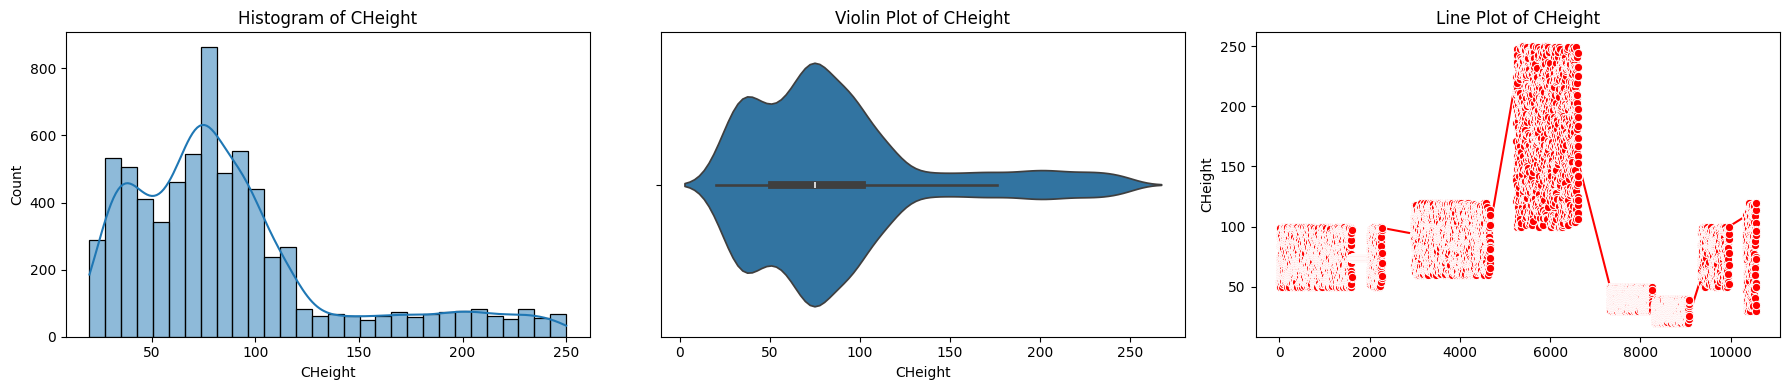

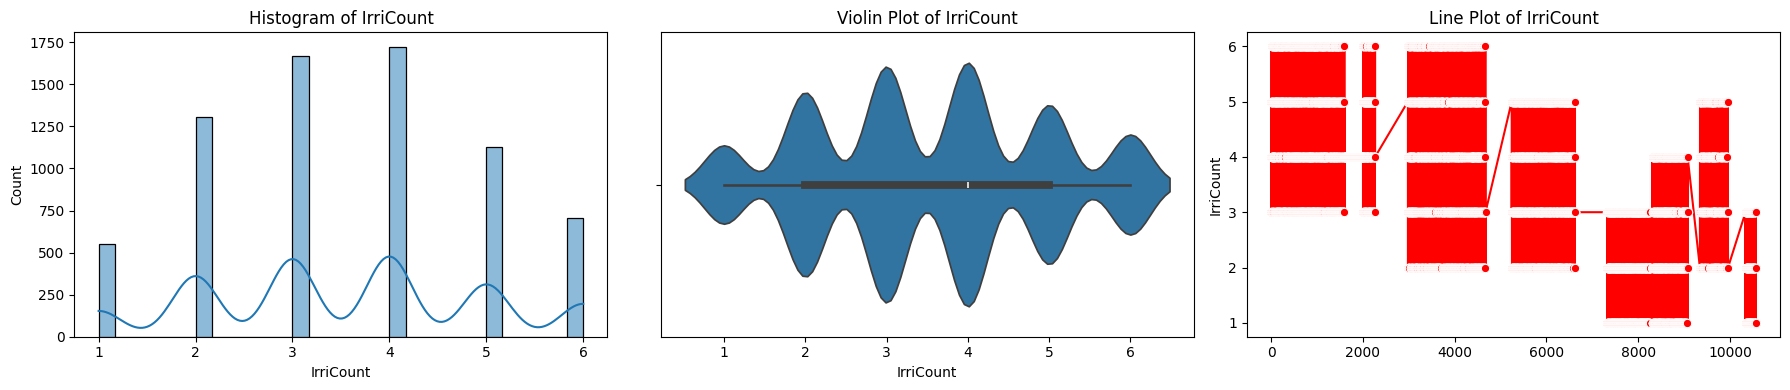

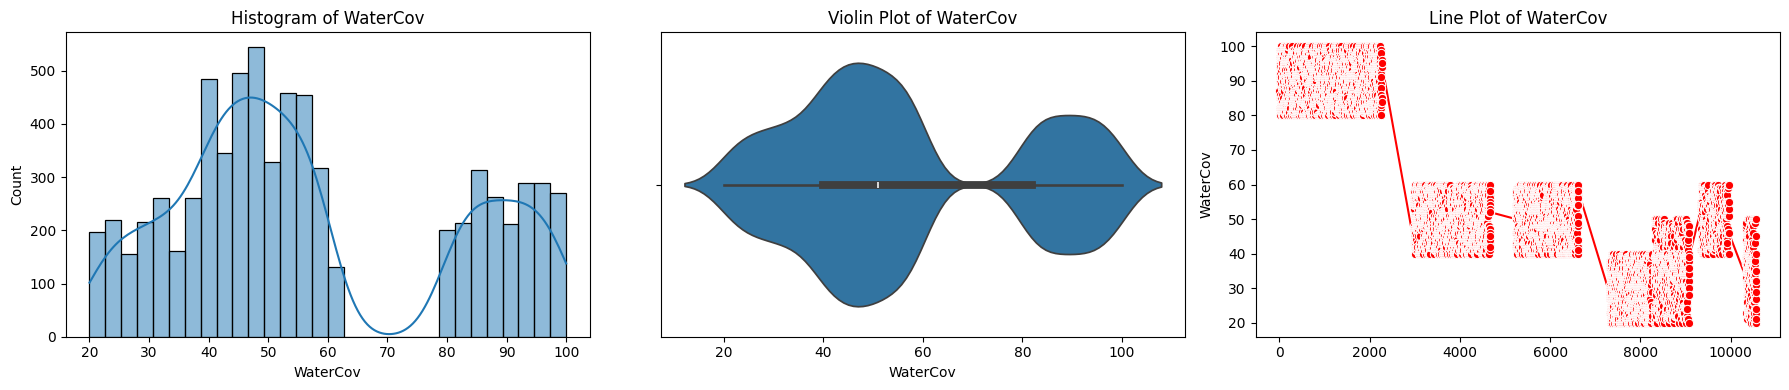

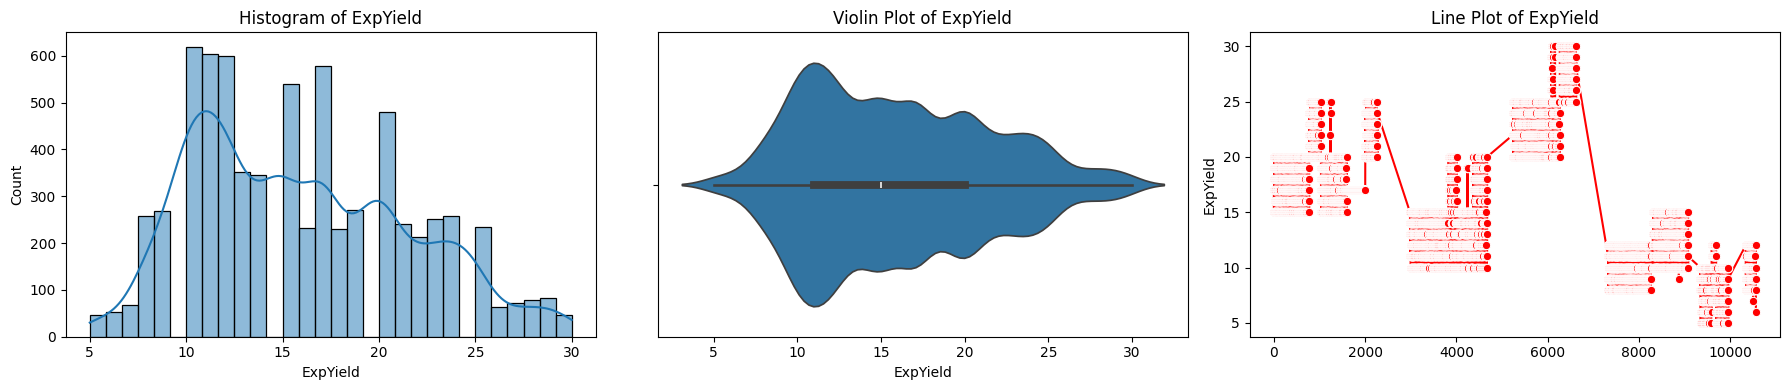

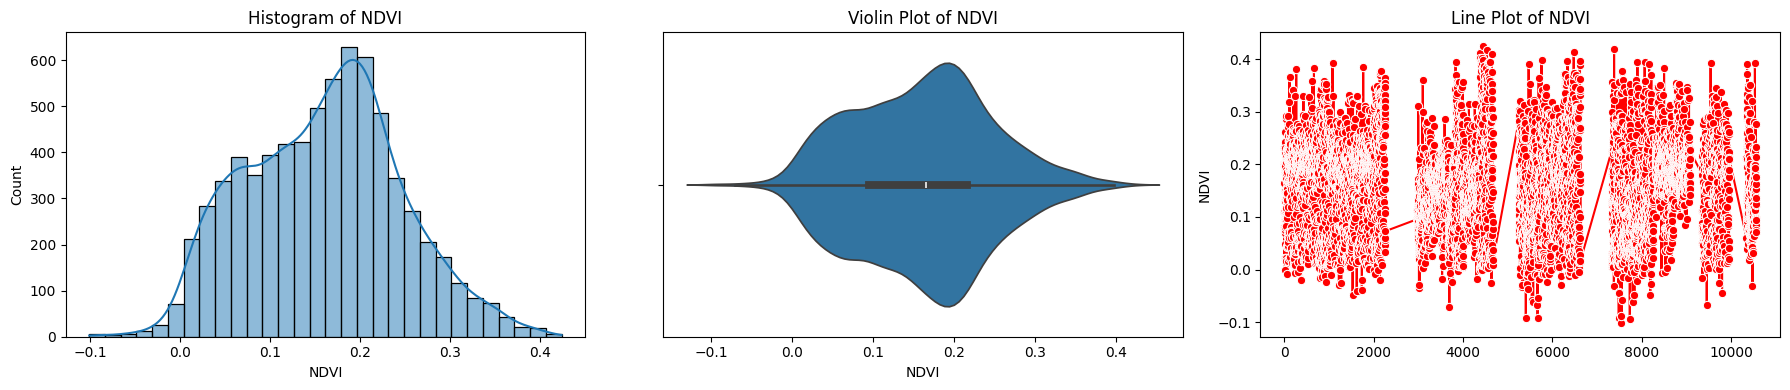

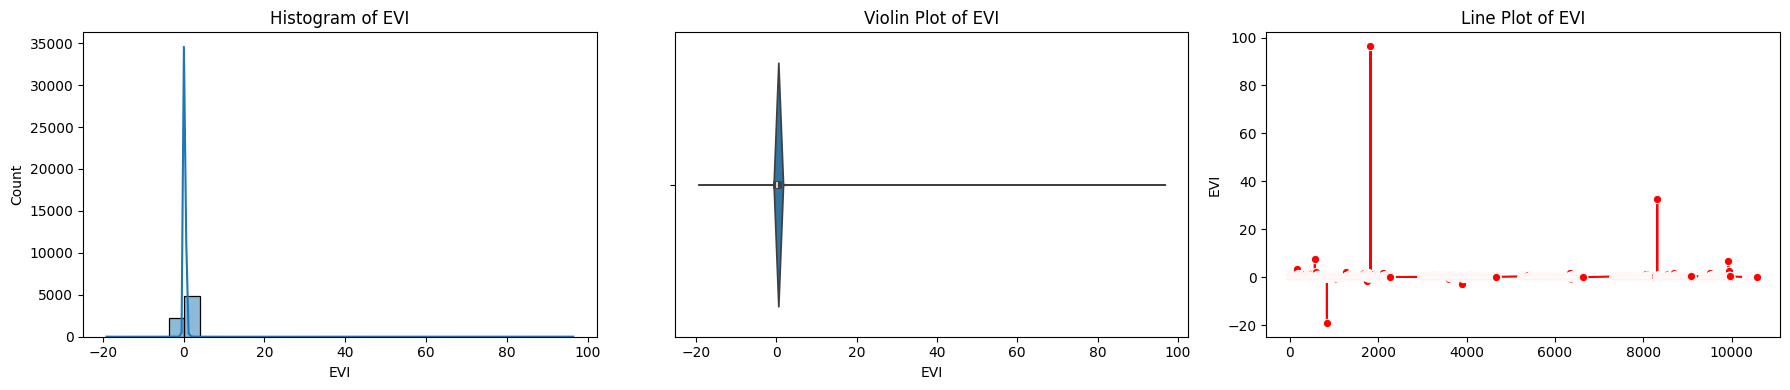

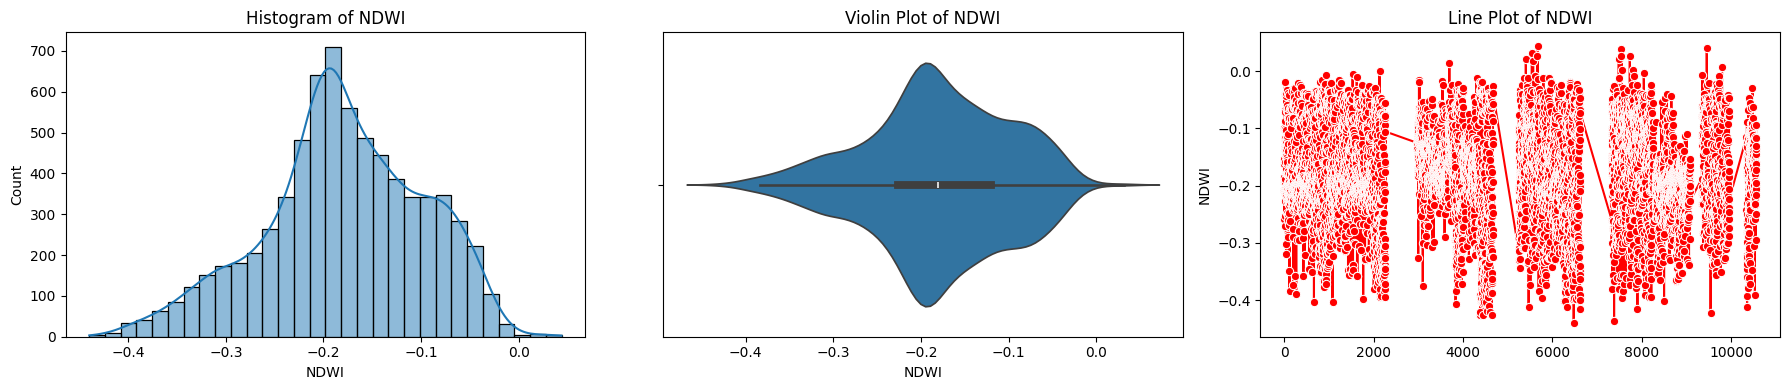

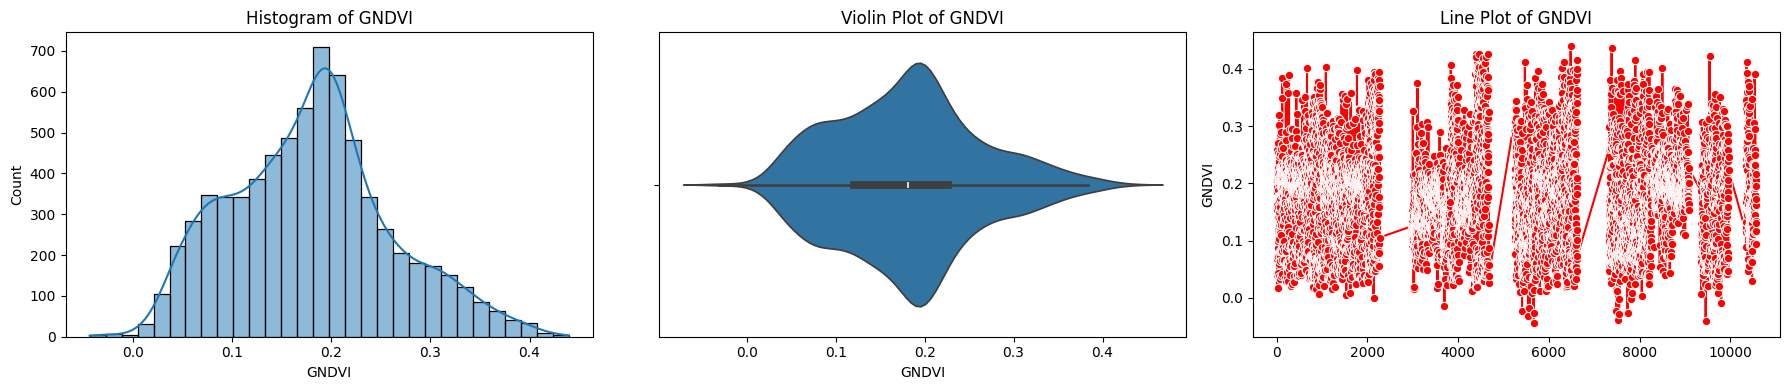

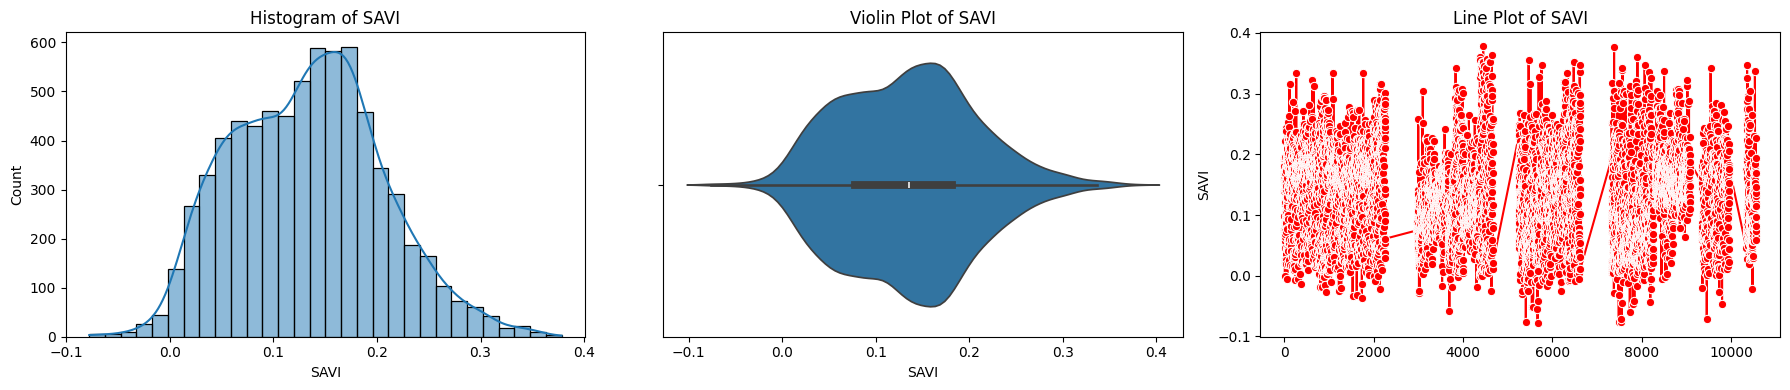

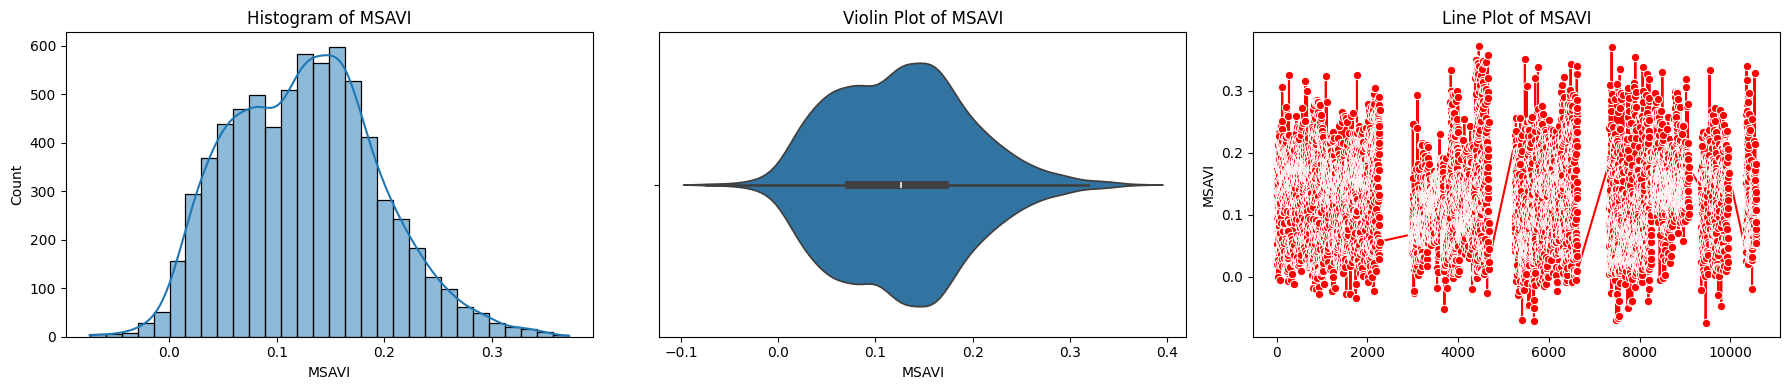

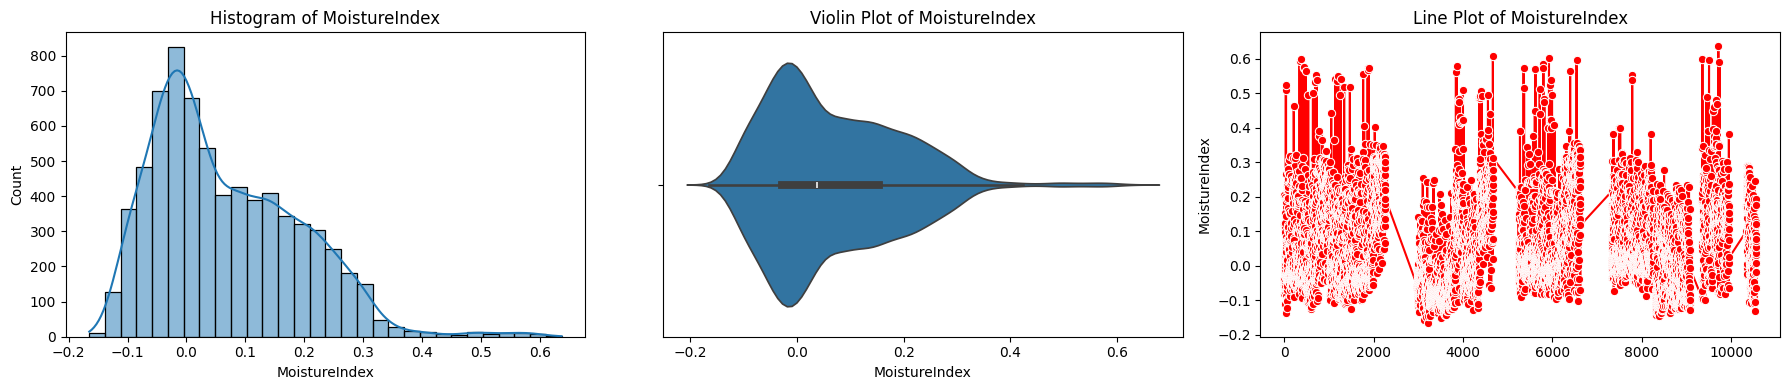

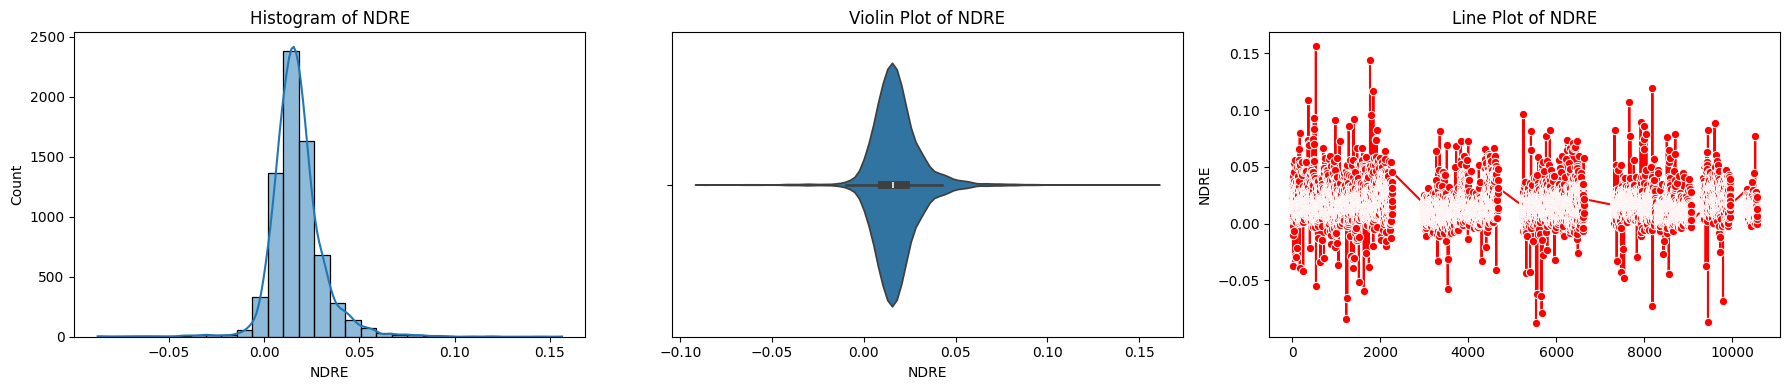

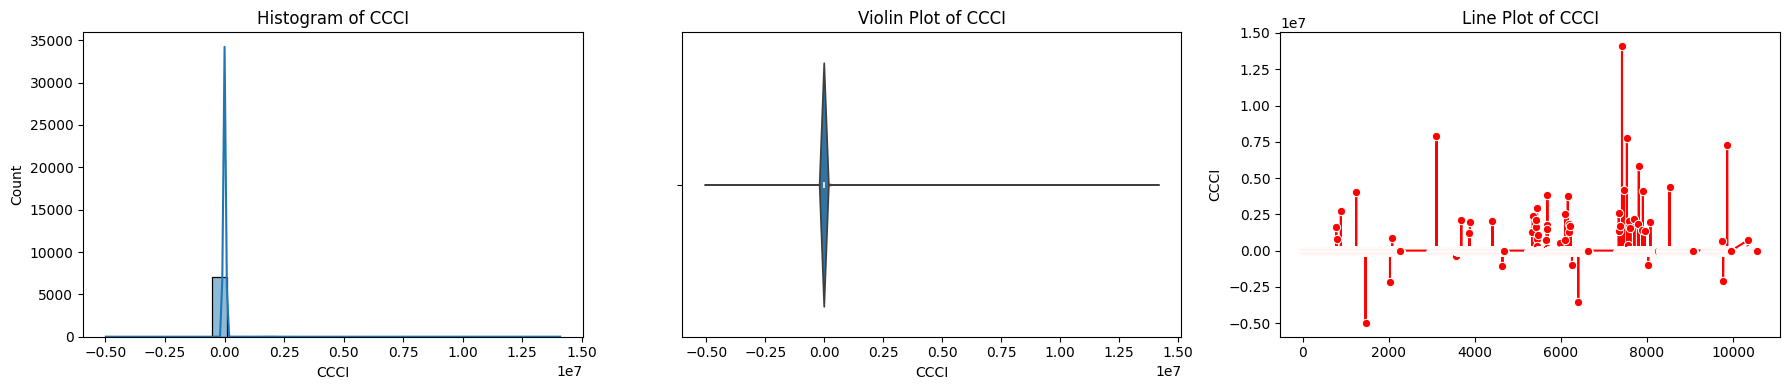

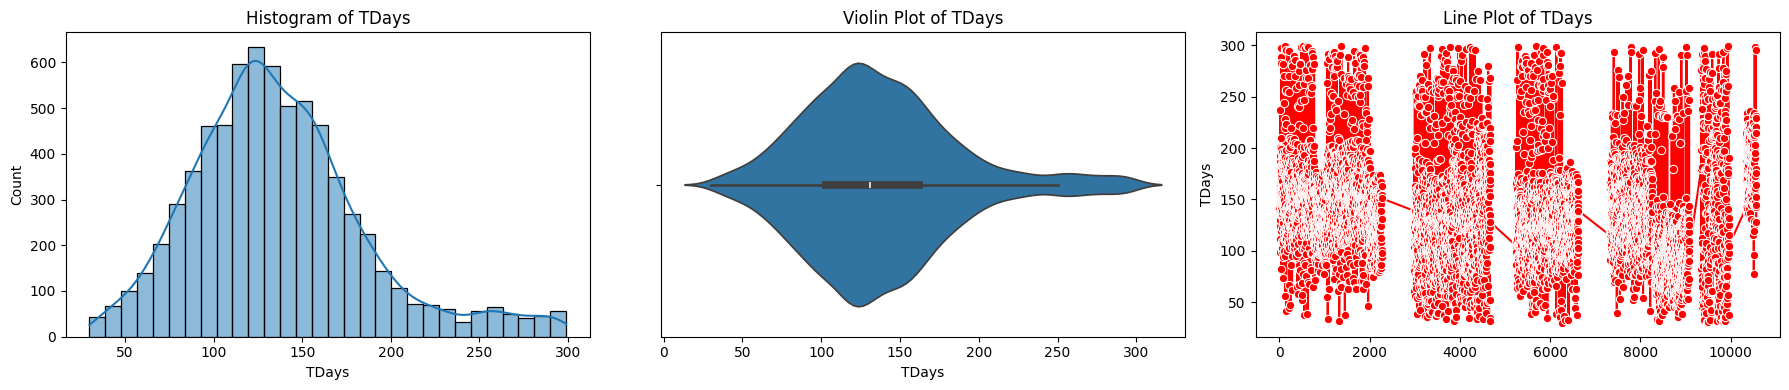

In [383]:
plot_numerical_distributions(train_idf)

### Post processing

In [218]:
category_mapper = {label: idx for idx, label in enumerate(train_data['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(train_data['category'].unique()) if pd.notna(label)}

In [471]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def prepare_model_data(df, type='train'):
    """
    Prepares data for machine learning by encoding categorical columns
    according to specified rules:
    - For 'train': 'category' is mapped to 'target' using label encoding.
    - 'Crop' is one-hot or label encoded.
    - 'CNext' and 'CLast' share the same encoding to maintain consistency.
    - 'CTransp', 'IrriType', 'IrriSource', and 'Season' are label encoded.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to process.
    type : str, optional (default='train')
        The type of data being processed ('train' or 'test').

    Returns:
    --------
    pandas.DataFrame
        Processed DataFrame ready for model training or testing.
    """

    # Handle 'category' only if type is 'train'
    if type == 'train' and 'category' in df.columns:
        # Encode 'category' to 'target'
        category_mapper = {label: idx for idx, label in enumerate(df['category'].unique()) if pd.notna(label)}
        df['target'] = df['category'].map(category_mapper)
        # Drop the original 'category' column now that we have 'target'
        df.drop(columns=['category'], inplace=True)

    # One-hot encoding or label encoding for 'Crop'
    if 'Crop' in df.columns:
        encoder = LabelEncoder()
        df['Crop'] = encoder.fit_transform(df['Crop'])

    # Consistent Label Encoding for 'CNext' and 'CLast'
    if 'CNext' in df.columns and 'CLast' in df.columns:
        combined_values = pd.concat([df['CNext'], df['CLast']]).unique()
        cl_encoder = LabelEncoder()
        cl_encoder.fit(combined_values)

        # Apply shared encoding to both columns
        df['CNext'] = cl_encoder.transform(df['CNext'])
        df['CLast'] = cl_encoder.transform(df['CLast'])

    # Label Encode other columns
    label_cols = ['CTransp', 'IrriType', 'IrriSource', 'Season']
    for col in label_cols:
        if col in df.columns:
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col])

    return df

In [473]:
model_df = prepare_model_data(train_idf)
model_df.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays,target
0,5,97,54,4,0,3,1,1,4,87,...,0.163293,-0.153967,0.153967,0.098089,0.094265,0.121053,0.013156,-0.005251,141,0
1,5,82,58,4,0,3,1,0,5,94,...,0.362191,-0.193252,0.193252,0.159491,0.148534,-0.037014,0.004742,0.023030,165,0
2,5,92,91,4,0,3,1,0,3,99,...,0.342884,-0.207029,0.207029,0.168543,0.158716,-0.041077,0.023218,0.112474,131,0
4,5,94,55,4,0,3,1,0,5,97,...,0.673206,-0.184704,0.184704,0.180863,0.174953,-0.082711,0.025535,0.126281,159,1
5,5,97,51,4,0,3,1,1,5,85,...,0.358449,-0.162412,0.162412,0.140404,0.132625,-0.054915,0.036126,0.218214,157,2


## Model Training 

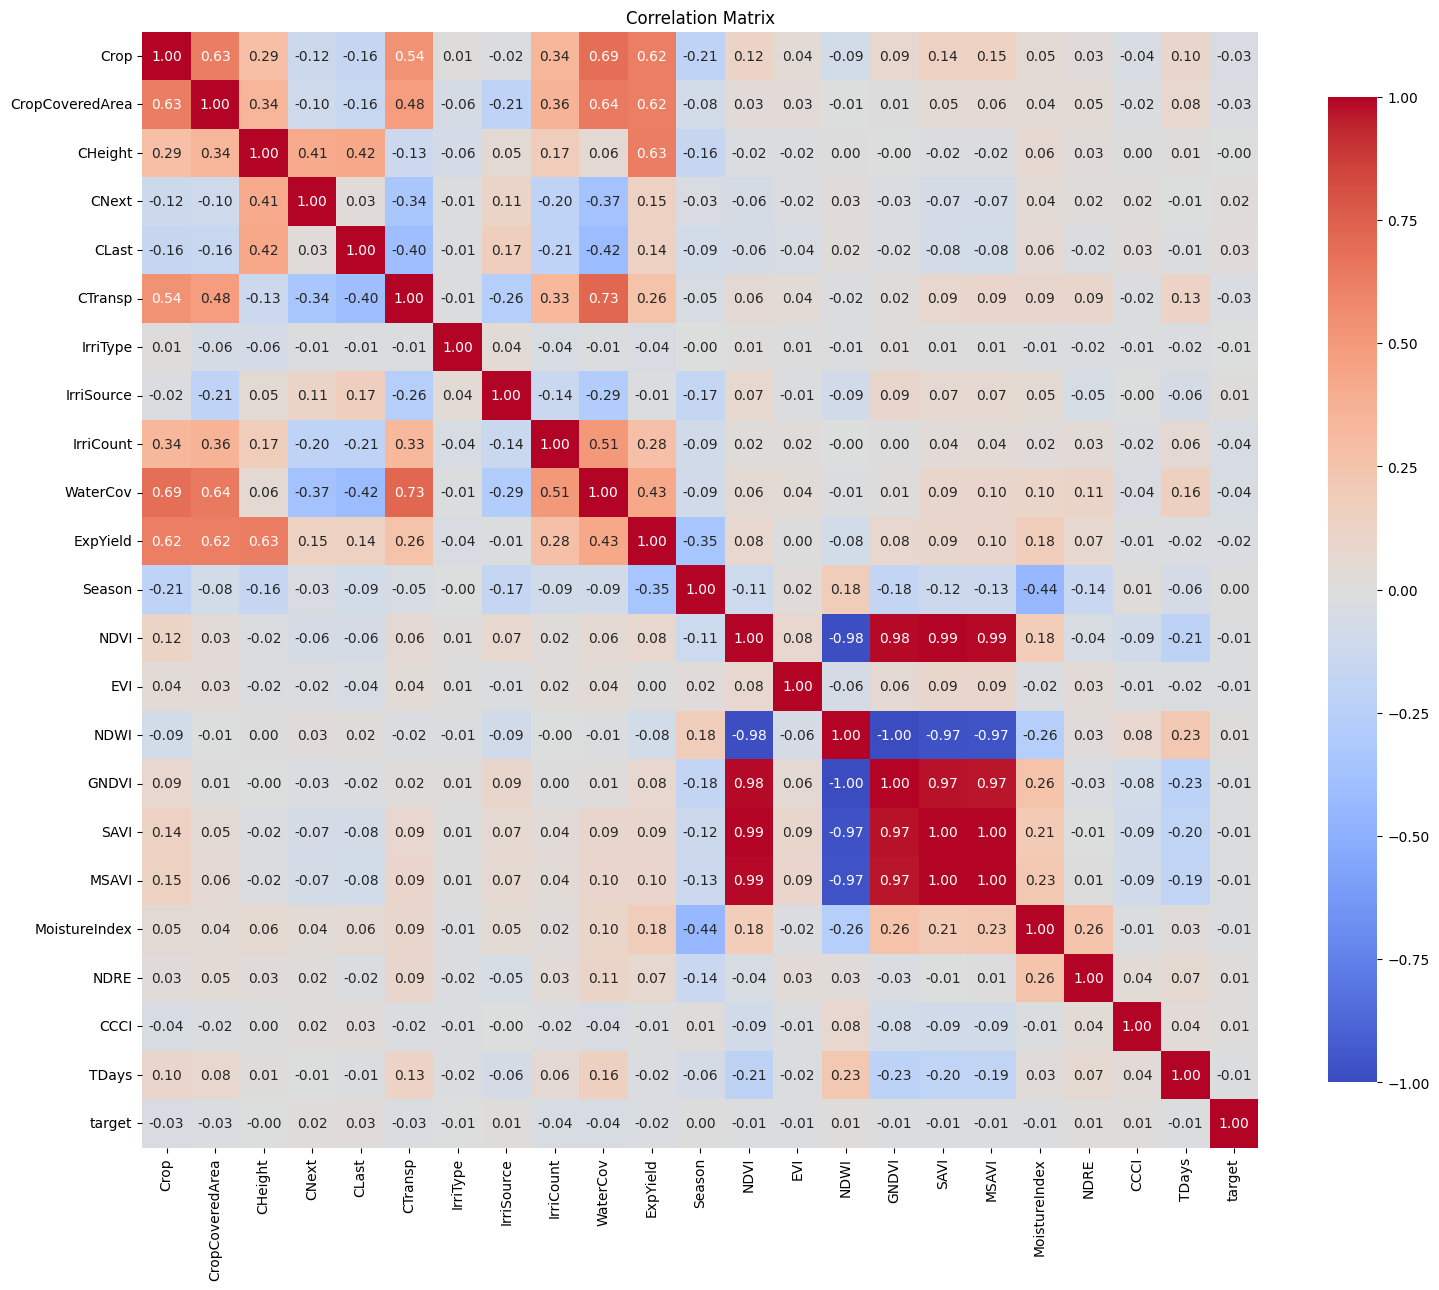

In [478]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
correlation_matrix = model_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [480]:
# Separate features and target variable in the train set
X = model_df.drop(columns=['target'])
y = model_df['target'].astype(int)

In [482]:
from sklearn.model_selection import StratifiedKFold, train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [484]:
X.describe()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays
count,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000,...,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7071.000000,7.071000e+03,7080.000000
mean,3.142938,77.804237,87.307062,4.457203,4.150282,1.577119,1.047881,0.789124,3.520198,56.885876,...,0.160094,0.284980,-0.179778,0.179778,0.133377,0.125995,0.067368,0.017439,1.554013e+04,136.732345
std,1.777866,14.186280,51.193517,3.082357,3.219829,1.137893,0.946870,0.784632,1.415767,23.124670,...,0.085769,1.247951,0.081404,0.081404,0.072050,0.069040,0.124125,0.013670,3.056858e+05,49.318162
min,0.000000,40.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,...,-0.101148,-19.056145,-0.439765,-0.043751,-0.077626,-0.074347,-0.164953,-0.087368,-4.981733e+06,30.000000
25%,2.000000,67.000000,51.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,40.000000,...,0.095105,0.154297,-0.226298,0.120737,0.077680,0.072493,-0.027921,0.009994,5.310537e-02,103.000000
50%,3.000000,79.000000,75.000000,4.000000,4.000000,2.000000,1.000000,1.000000,4.000000,51.000000,...,0.165626,0.255762,-0.181226,0.181226,0.135231,0.126301,0.037125,0.016143,9.593426e-02,131.000000
75%,5.000000,90.000000,101.000000,7.000000,7.000000,3.000000,2.000000,1.000000,5.000000,82.000000,...,0.216601,0.342067,-0.120737,0.226298,0.181074,0.171196,0.152847,0.023039,1.989960e-01,162.000000
max,6.000000,100.000000,250.000000,9.000000,9.000000,3.000000,3.000000,4.000000,6.000000,100.000000,...,0.424395,96.387720,0.043751,0.439765,0.378199,0.371833,0.636575,0.156441,1.409063e+07,299.000000


## Model development

In [486]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
# class_weight='balanced' automatically uses the inverse of class frequencies
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [488]:
# Predict on the validation set
y_pred = rf_model.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.83      1.00      0.90      1170
    Diseased       0.00      0.00      0.00        86
       Pests       0.00      0.00      0.00        86
    Stressed       0.00      0.00      0.00        74

    accuracy                           0.82      1416
   macro avg       0.21      0.25      0.23      1416
weighted avg       0.68      0.82      0.75      1416


Weighted F1 Score: 0.7469696174633992


/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


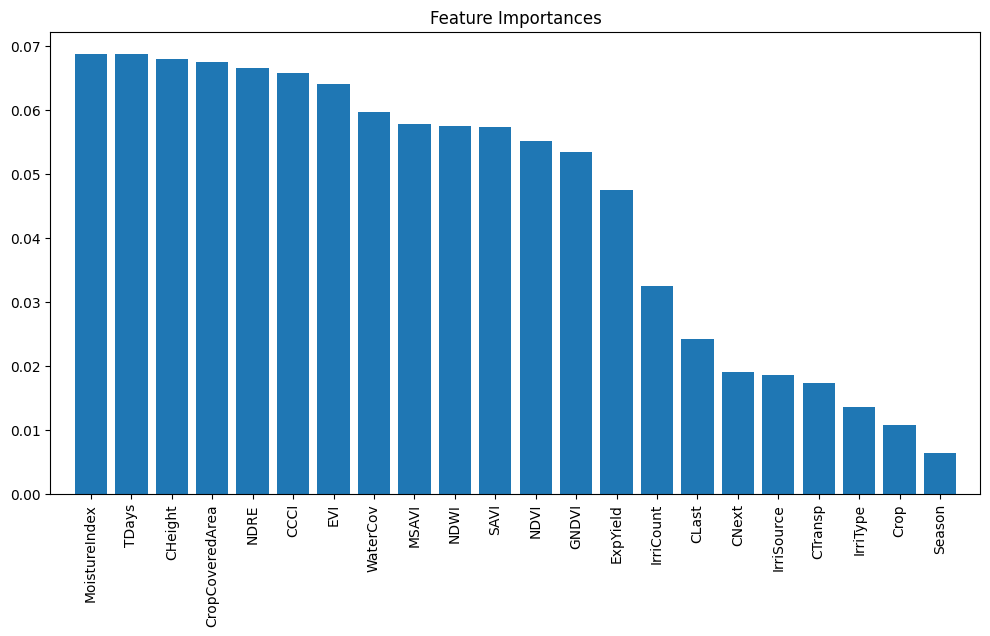

In [490]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### LGBM Model

In [493]:
from lightgbm import LGBMClassifier

# Specify class weights manually, e.g., {Healthy: 1, Diseased: some weight, etc.}
weights = {
    'Healthy': 1.0,
    'Diseased': 10.0,
    'Pests': 10.0,
    'Stressed': 15.0
}

# Convert these into an array matching numeric labels
# e.g., if 'Healthy' is label 0, 'Diseased' is label 1, etc.
# The easiest approach is often to let LGBM handle it via 'is_unbalance=True'
# or provide class_weight directly if your data is numeric-coded.

lgbm = LGBMClassifier(
    class_weight='balanced',
    max_depth = 10, 
    learning_rate = 0.1,
    n_estimators = 200,
    random_state=42, 
)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2958
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=10,
               n_estimators=200, random_state=42)

In [495]:
# Predict on the validation set
y_pred = lgbm.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      0.85      0.84      1170
    Diseased       0.11      0.10      0.11        86
       Pests       0.07      0.06      0.06        86
    Stressed       0.07      0.05      0.06        74

    accuracy                           0.71      1416
   macro avg       0.27      0.27      0.27      1416
weighted avg       0.70      0.71      0.70      1416


Weighted F1 Score: 0.7043338652913215


In [112]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

def tune_lgbm(X_train, y_train, X_test, y_test):
    """
    Optimize LGBMClassifier for imbalanced data using Stratified K-Fold CV, 
    SMOTE, GPU, early stopping, and hyperparameter tuning.

    Parameters:
    -----------
    X_train : DataFrame
        Training features
    y_train : Series
        Training labels
    X_test : DataFrame
        Test features
    y_test : Series
        Test labels

    Returns:
    --------
    Best Model, Classification Report
    """

    # Define the classifier with GPU support and early stopping
    lgbm = LGBMClassifier(
        boosting_type='gbdt',
        objective='multiclass',
        random_state=42,
        class_weight='balanced',
        device='cpu',  # Use GPU for Apple M3 or CUDA (if on Nvidia)
        gpu_platform_id=0,
        gpu_device_id=0
    )

    # Define hyperparameters for Randomized Search
    param_grid = {
        'num_leaves': [20, 30, 50],            
        'learning_rate': [0.01, 0.05, 0.1],   
        'n_estimators': [50, 100, 200],      
        'max_depth': [-1, 10, 15],            
        'subsample': [0.7, 0.8, 1.0],         
        'reg_lambda': [1, 5],             
        'reg_alpha': [1, 5]
    }

    # Implement Stratified K-Fold to balance each fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Randomized Search (faster than Grid Search)
    randomized_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_grid,
        n_iter=30,  # Try 30 random combinations
        scoring='f1_macro',
        cv=skf,
        n_jobs=-1,
        verbose=2
    )
    # Fit the model with early stopping via fit_params
    fit_params = {
        'eval_set': [(X_test, y_test)],
        'eval_metric': 'multi_logloss',
    }

    # Fit the model with early stopping
    randomized_search.fit(
        X_train, y_train,
        **fit_params
    )

    # Best Model after tuning
    best_model = randomized_search.best_estimator_

    # Evaluate on test data
    y_pred = best_model.predict(X_test)

    # Classification Report
    print("Best Hyperparameters:", randomized_search.best_params_)
    print("F1-Score (Macro):", f1_score(y_test, y_pred, average='macro'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return best_model, randomized_search.best_params_

In [110]:
best_model, best_params = tune_lgbm(X_train, y_train, X_valid, y_valid)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2949
[LightGBM] [Info] Number of data points in the train set: 3964, number of used features: 28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2943
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Number of data points in the train set: 3965, number of used features: 28
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [In

## Model Testing & Submission

In [122]:
!ls ../

LICENSE.rst            models                 setup.cfg
Makefile               notebooks              setup.py
README.rst             readthedocs.yml        src
Starter_Notebook.ipynb references             test_environment.py
data                   reports                tox.ini
docs                   requirements.txt
environment.yml        requirements_pre.txt


In [124]:
test_csv = '../data/raw/gee_downloads_test/s2path_test_data.csv'
test_data = pd.read_csv(test_csv)
test_data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,dataset,SMonth,SDay,HMonth,HDay,MonthBetw,CorrectSDate,CorrectHDate,CorrectMonthBetw,tif_path
0,85197,NaN,Paddy,Telangana,Medak,Nizampet,11/12/23,5/14/24,81,99,...,test,11,12,5,14,6,2023-11-12,2024-05-14,6.0,../data/raw/gee_downloads_test/20240512T050649...
1,779677,NaN,Paddy,Telangana,Medak,Nizampet,12/20/23,5/28/24,91,63,...,test,12,20,5,28,5,2023-12-20,2024-05-28,5.0,../data/raw/gee_downloads_test/20240527T050651...
2,1331840,NaN,Paddy,Telangana,Medak,Nizampet,11/29/23,5/18/24,94,89,...,test,11,29,5,18,5,2023-11-29,2024-05-18,5.0,../data/raw/gee_downloads_test/20240517T050651...
3,483053,NaN,Paddy,Telangana,Medak,Nizampet,1/11/23,4/27/24,83,78,...,test,1,11,4,27,15,2023-11-01,2024-04-27,5.0,../data/raw/gee_downloads_test/20240422T050649...
4,542945,NaN,Paddy,Telangana,Medak,Nizampet,4/11/23,4/25/24,82,53,...,test,4,11,4,25,12,2023-11-04,2024-04-25,5.0,../data/raw/gee_downloads_test/20240422T050649...


In [126]:
test_idf = compute_indices_for_df(test_data, tif_path_col='tif_path')

Error processing row 9 with TIF path ../data/raw/gee_downloads_test/20240412T050649_20240412T051727_T44QKD_RGB_2023-11-24_2024-04-16.tif: ../data/raw/gee_downloads_test/20240412T050649_20240412T051727_T44QKD_RGB_2023-11-24_2024-04-16.tif: No such file or directory
Error processing row 196 with TIF path ../data/raw/gee_downloads_test/20240407T050651_20240407T051729_T44QKE_RGB_2023-11-21_2024-04-08.tif: ../data/raw/gee_downloads_test/20240407T050651_20240407T051729_T44QKE_RGB_2023-11-21_2024-04-08.tif: No such file or directory
Error processing row 197 with TIF path ../data/raw/gee_downloads_test/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-05_2024-05-21.tif: ../data/raw/gee_downloads_test/20240517T050651_20240517T051655_T44QKE_RGB_2023-12-05_2024-05-21.tif: No such file or directory


In [465]:
test_idf.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays,target
0,Paddy,81,99,Lentil,Pea,Transplanting,Flood,Groundwater,5,81,...,0.471654,-0.187639,0.187639,0.167257,0.160503,-0.049754,0.018703,0.098551,184,NaN
1,Paddy,91,63,Lentil,Pea,Transplanting,Flood,Canal,5,97,...,0.134927,-0.064469,0.064469,0.045313,0.045465,0.295565,0.013738,0.263905,160,NaN
2,Paddy,94,89,Pea,Lentil,Transplanting,Flood,Canal,5,88,...,0.278366,-0.112555,0.112555,0.078476,0.076582,0.004527,0.015553,0.850858,171,NaN
3,Paddy,83,78,Pea,Lentil,Transplanting,Flood,Canal,5,98,...,0.295986,-0.228758,0.228758,0.179850,0.169431,0.099199,0.019943,0.090531,178,NaN
4,Paddy,82,53,Lentil,Pea,Transplanting,Flood,Canal,6,98,...,0.385031,-0.233018,0.233018,0.193744,0.184323,0.051520,0.019223,0.083434,173,NaN


In [497]:
model_test_df = prepare_model_data(test_idf, type='test')
model_test_df.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays,target
0,5,81,99,0,4,3,1,1,5,81,...,0.471654,-0.187639,0.187639,0.167257,0.160503,-0.049754,0.018703,0.098551,184,NaN
1,5,91,63,0,4,3,1,0,5,97,...,0.134927,-0.064469,0.064469,0.045313,0.045465,0.295565,0.013738,0.263905,160,NaN
2,5,94,89,4,0,3,1,0,5,88,...,0.278366,-0.112555,0.112555,0.078476,0.076582,0.004527,0.015553,0.850858,171,NaN
3,5,83,78,4,0,3,1,0,5,98,...,0.295986,-0.228758,0.228758,0.179850,0.169431,0.099199,0.019943,0.090531,178,NaN
4,5,82,53,0,4,3,1,0,6,98,...,0.385031,-0.233018,0.233018,0.193744,0.184323,0.051520,0.019223,0.083434,173,NaN


In [499]:
SX_data = model_test_df.drop(columns=['target'])
SX_data.head()

,Crop,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,...,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays
0,5,81,99,0,4,3,1,1,5,81,...,0.188792,0.471654,-0.187639,0.187639,0.167257,0.160503,-0.049754,0.018703,0.098551,184
1,5,91,63,0,4,3,1,0,5,97,...,0.044991,0.134927,-0.064469,0.064469,0.045313,0.045465,0.295565,0.013738,0.263905,160
2,5,94,89,4,0,3,1,0,5,88,...,0.085594,0.278366,-0.112555,0.112555,0.078476,0.076582,0.004527,0.015553,0.850858,171
3,5,83,78,4,0,3,1,0,5,98,...,0.216831,0.295986,-0.228758,0.228758,0.179850,0.169431,0.099199,0.019943,0.090531,178
4,5,82,53,0,4,3,1,0,6,98,...,0.227358,0.385031,-0.233018,0.233018,0.193744,0.184323,0.051520,0.019223,0.083434,173


In [503]:
test_predictions = lgbm.predict(SX_data)

In [543]:
len(test_predictions)

2718

In [549]:
test_data['Target'] = test_predictions
test_data['Target'] = test_data['Target'].astype(int).map(idx_to_category_mapper)
test_data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays,pred_target,Target
0,85197,NaN,Paddy,Telangana,Medak,Nizampet,11/12/23,5/14/24,81,99,...,-0.187639,0.187639,0.167257,0.160503,-0.049754,0.018703,0.098551,184,0,Healthy
1,779677,NaN,Paddy,Telangana,Medak,Nizampet,12/20/23,5/28/24,91,63,...,-0.064469,0.064469,0.045313,0.045465,0.295565,0.013738,0.263905,160,1,Diseased
2,1331840,NaN,Paddy,Telangana,Medak,Nizampet,11/29/23,5/18/24,94,89,...,-0.112555,0.112555,0.078476,0.076582,0.004527,0.015553,0.850858,171,0,Healthy
3,483053,NaN,Paddy,Telangana,Medak,Nizampet,1/11/23,4/27/24,83,78,...,-0.228758,0.228758,0.179850,0.169431,0.099199,0.019943,0.090531,178,0,Healthy
4,542945,NaN,Paddy,Telangana,Medak,Nizampet,4/11/23,4/25/24,82,53,...,-0.233018,0.233018,0.193744,0.184323,0.051520,0.019223,0.083434,173,0,Healthy


In [571]:
submission_df = test_data[["FarmID", "Target"]]
submission_df.to_csv('../data/submission1.csv', index=False)

In [573]:
submission_df.groupby('Target').count()

,FarmID
Target,
Diseased,150
Healthy,2346
Pests,122
Stressed,100


In [561]:
sdf = pd.read_csv('../data/submission.csv')

In [563]:
sdf.groupby('Target').count()

,ID
Target,
Diseased,130
Healthy,2312
Pests,173
Stressed,103


In [565]:
train_data.groupby('category').count()

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,...,NDVI,EVI,NDWI,GNDVI,SAVI,MSAVI,MoistureIndex,NDRE,CCCI,TDays
category,,,,,,,,,,,,,,,,,,,,,
Diseased,429,429,429,429,429,429,429,429,429,429,...,428,428,428,428,428,428,428,428,428,429
Healthy,5850,5850,5850,5850,5850,5850,5850,5850,5850,5850,...,5843,5843,5843,5843,5843,5843,5843,5843,5843,5850
Pests,430,430,430,430,430,430,430,430,430,430,...,430,430,430,430,430,430,430,430,430,430
Stressed,371,371,371,371,371,371,371,371,371,371,...,370,370,370,370,370,370,370,370,370,371
